In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 

In [2]:
import tsfresh.examples.robot_execution_failures as robot

robot.download_robot_execution_failures()

In [5]:
import os
robot.data_file_name

'/Users/akem134/opt/anaconda3/envs/dslab/lib/python3.8/site-packages/tsfresh/examples/data/robotfailure-mld/lp1.data'

In [6]:
ts, label = robot.load_robot_execution_failures()

In [8]:
ts.shape

(1320, 8)

In [10]:
label.shape

(88,)

In [12]:
label.unique()

array([ True, False])

In [13]:
ts

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [14]:
from tsfresh import extract_features

X = extract_features(ts, column_id='id', column_sort='time')

Feature Extraction: 100%|██████████████████████████████████| 38/38 [00:05<00:00,  7.08it/s]


In [15]:
X.shape

(88, 4734)

In [16]:
4734 / 6

789.0

In [17]:
X.isna().sum()

F_x__variance_larger_than_standard_deviation              0
F_x__has_duplicate_max                                    0
F_x__has_duplicate_min                                    0
F_x__has_duplicate                                        0
F_x__sum_values                                           0
                                                         ..
T_z__matrix_profile__feature_"mean"__threshold_0.98      88
T_z__matrix_profile__feature_"median"__threshold_0.98    88
T_z__matrix_profile__feature_"25"__threshold_0.98        88
T_z__matrix_profile__feature_"75"__threshold_0.98        88
T_z__mean_n_absolute_max__number_of_maxima_7              0
Length: 4734, dtype: int64

In [19]:
Xreal = X.dropna(axis=1)
Xreal.shape

(88, 2215)

In [20]:
from tsfresh.transformers import FeatureSelector

select = FeatureSelector()

In [21]:
select.fit(Xreal, label)

FeatureSelector()

In [22]:
p_values = pd.Series(select.p_values, index=select.features)
p_values

F_x__value_count__value_-1                                         1.879633e-12
F_x__root_mean_square                                              5.900086e-12
F_x__abs_energy                                                    5.900086e-12
T_y__absolute_maximum                                              5.966395e-12
F_x__mean_n_absolute_max__number_of_maxima_7                       6.054628e-12
                                                                       ...     
T_z__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"             NaN
T_z__ratio_beyond_r_sigma__r_5                                              NaN
T_z__ratio_beyond_r_sigma__r_6                                              NaN
T_z__ratio_beyond_r_sigma__r_7                                              NaN
T_z__ratio_beyond_r_sigma__r_10                                             NaN
Length: 2215, dtype: float64

In [23]:
len(select.relevant_features)

675

# Find a really good feature for discriminating the labels

In [25]:
Xreal[select.relevant_features].shape

(88, 675)

In [27]:
select.transform(Xreal).shape

(88, 675)

In [29]:
np.alltrue(Xreal[select.relevant_features] == 
          select.transform(Xreal))

True

In [31]:
Xrel = select.transform(Xreal)
Xrel.shape

(88, 675)

In [36]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(Xrel, label)

DecisionTreeClassifier(random_state=0)

In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(label, clf.predict(Xrel))

array([[67,  0],
       [ 0, 21]])

[Text(0.5, 0.75, 'F_x__abs_energy <= 68.5\ngini = 0.363\nsamples = 88\nvalue = [67, 21]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 67\nvalue = [67, 0]')]

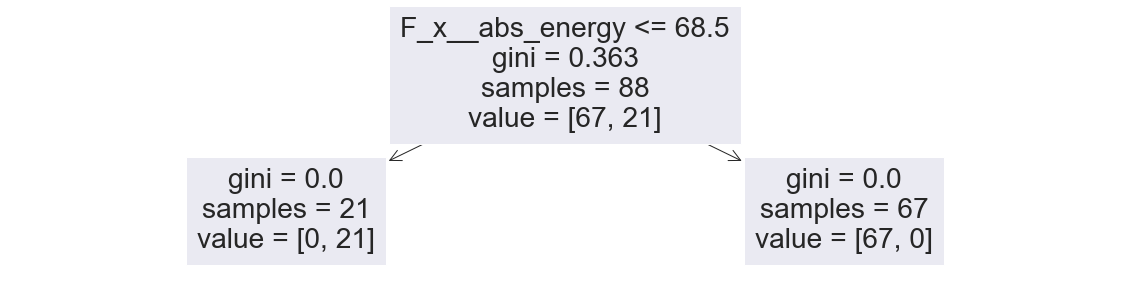

In [38]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 5))
plot_tree(clf, feature_names=Xrel.columns)

`F_x__abs_energy` = $\sum\limits_{j=1}^T F_x[j]^2$

Gini impurity of node $i$ is 

$G_i = 1 - \sum\limits_{k\in\mathcal{C}} p_{i,k}^2$

with $p_{i,k}$ is the ratio of class $k\in\mathcal{C}=\{\mathtt{True}, \mathtt{False}\}$ instances among the training instances in the $i^\text{th}$ node.

In [46]:
# Calculate Gini of top node
# np.sum(label) counts the number of samples with label True
# np.sum(~label) counts the number of samples with label False
1 - ((np.sum(label)/88)**2      # k = True
     +(np.sum(~label)/88)**2    # k = False
    )

0.3633780991735538

# Homework

Use `cross_val_predict` to evaluate the performance of the classifier for out-of-sample predictions.

In [44]:
from sklearn.model_selection import cross_val_predict